In [34]:
import segmentation_models as sm

import tensorflow as tf

sm.set_framework('tf.keras')

from cnn.input import PascalVOC2012Dataset, Dataloader, get_training_augmentation, get_preprocessing, visualize, denormalize

import os

import matplotlib.pyplot as plt

import numpy as np

In [35]:
train_dataset_descriptor_filepath = os.path.join(
    'pascalvoc12',
    'VOCdevkit',
    'VOC2012',
    'ImageSets',
    'Segmentation',
    'train.txt',
)

val_dataset_descriptor_filepath = os.path.join(
    'pascalvoc12',
    'VOCdevkit',
    'VOC2012',
    'ImageSets',
    'Segmentation',
    'val.txt',
)

images_path = os.path.join(
    'pascalvoc12', 
    'VOCdevkit', 
    'VOC2012', 
    'JPEGImages'
)

masks_path = os.path.join(
    'pascalvoc12', 
    'VOCdevkit', 
    'VOC2012', 
    'SegmentationClass'
) 

In [36]:
image_height = 224
image_width = 224
backbone = 'efficientnetb1'

In [37]:
train_dataset = PascalVOC2012Dataset(
    train_dataset_descriptor_filepath,
    images_path=images_path,
    masks_path=masks_path,
    image_height=image_height,
    image_width=image_width,
    augmentation=get_training_augmentation(image_height, image_width),
    preprocessing=get_preprocessing(sm.get_preprocessing(backbone))
)

val_dataset = PascalVOC2012Dataset(
    val_dataset_descriptor_filepath,
    images_path=images_path,
    masks_path=masks_path,
    image_height=image_height,
    image_width=image_width,
    preprocessing=get_preprocessing(sm.get_preprocessing(backbone))
)

/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:2029: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


In [38]:
train_dataloader = Dataloader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = Dataloader(val_dataset, batch_size=2, shuffle=False)

In [39]:
net = sm.Unet(backbone, classes=21, input_shape=(image_height, image_width, 3), activation='softmax', encoder_weights='imagenet')

In [40]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

In [41]:
net.compile(                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=sm.losses.cce_jaccard_loss,
    metrics=[MyMeanIOU(num_classes=21, name='mean_iou')],
)

In [42]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

history = net.fit(train_dataloader, 
                validation_data=val_dataloader,
                epochs=50,
                callbacks=callbacks
            )

Epoch 1/50
732/732 [==============================] - 491s 659ms/step - loss: 1.0423 - mean_iou: 0.0385 - val_loss: 1.0039 - val_mean_iou: 0.0689 - lr: 1.0000e-04
Epoch 2/50
732/732 [==============================] - 475s 648ms/step - loss: 1.0113 - mean_iou: 0.0480 - val_loss: 0.9949 - val_mean_iou: 0.0813 - lr: 1.0000e-04
Epoch 3/50
732/732 [==============================] - 467s 639ms/step - loss: 1.0059 - mean_iou: 0.0528 - val_loss: 0.9892 - val_mean_iou: 0.0840 - lr: 1.0000e-04
Epoch 4/50
732/732 [==============================] - 474s 647ms/step - loss: 1.0042 - mean_iou: 0.0548 - val_loss: 0.9820 - val_mean_iou: 0.0918 - lr: 1.0000e-04
Epoch 5/50
732/732 [==============================] - 474s 648ms/step - loss: 0.9991 - mean_iou: 0.0570 - val_loss: 0.9787 - val_mean_iou: 0.0954 - lr: 1.0000e-04
Epoch 6/50
732/732 [==============================] - 475s 649ms/step - loss: 0.9960 - mean_iou: 0.0603 - val_loss: 0.9786 - val_mean_iou: 0.1022 - lr: 1.0000e-04
Epoch 7/50
732/732 [==

In [ ]:
net.load_weights('best_model.h5') 

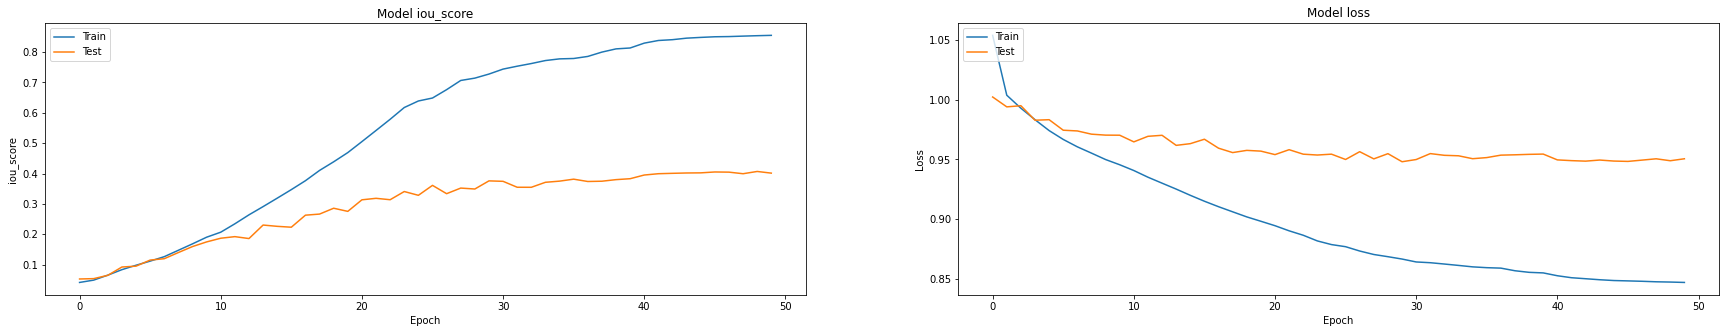

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['my_mean_iou'])
plt.plot(history.history['val_my_mean_iou'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 62ms/step


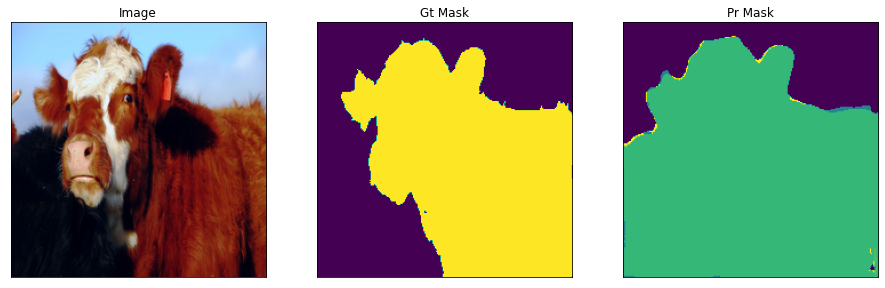

1/1 [==============================] - 0s 50ms/step


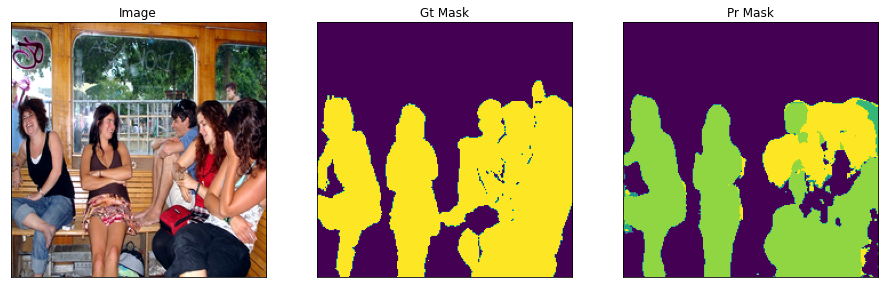

1/1 [==============================] - 0s 48ms/step


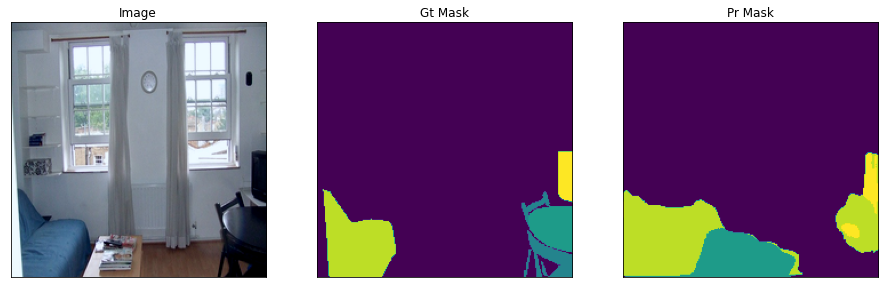

1/1 [==============================] - 0s 53ms/step


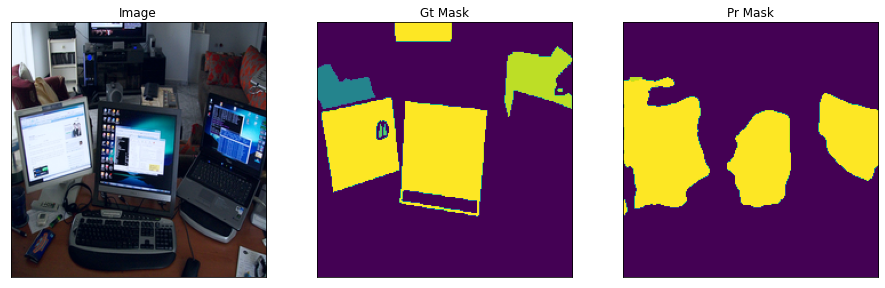

1/1 [==============================] - 0s 51ms/step


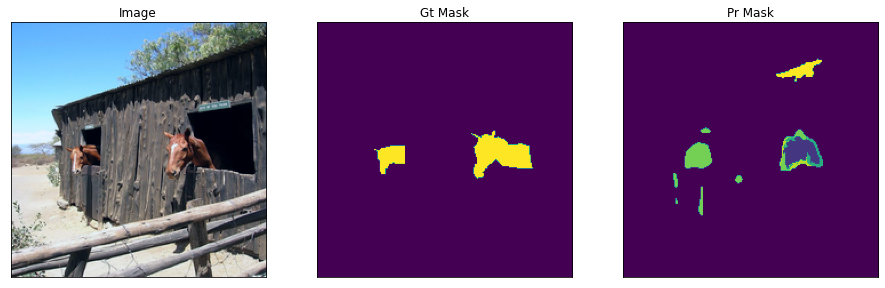

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(val_dataset)), size=n)

for i in ids:
    
    image, gt_mask = val_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = net.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()), 
        gt_mask=np.argmax(gt_mask.squeeze(), axis=-1),
        pr_mask=np.argmax(pr_mask.squeeze(), axis=-1),
    )
